In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon, mapping, shape
import shapely.wkt
from shapely.ops import cascaded_union
from pyproj import Proj, transform
import json


In [46]:
from shapely.geometry import LineString, Polygon

EPSG_4326 = Proj(init='EPSG:4326')
DEFAULT_EXPANSION_SIZE = 25000  # Meters


def flatten(geometries):
    combined = geometries.pop() if geometries else None
    for geo in geometries:
        combined = combined.union(geo)
    return combined


def expand_into_polygon(geometry, size=DEFAULT_EXPANSION_SIZE):
    if geometry.geom_type == 'Point':
        coords = _square_of_size(size)
        point = geometry
    elif geometry.geom_type == 'LineString':
        coords = _line_to_strip(geometry, size)
        point = geometry.centroid
    else:
        raise TypeError('Only geometries of type Point or LineString can expand into a Polygon.')
    coords = _local_to_global_coords(coords, point.y, point.x)
    return Polygon(coords)


def _square_of_size(size):
    half = int(size / 2)
    return [(-half, -half), (half, -half), (half, half), (-half, half), (-half, -half)]


def _line_to_strip(line, size):
    coords = global_to_local_coords(line.coords, line.centroid.y, line.centroid.x)
    laea_line = LineString(coords)
    x1, y1 = laea_line.coords[0]
    x2, y2 = laea_line.coords[1]
    angle_r = atan2(y2 - y1, x2 - x1)
    return _make_strip(angle_r, laea_line.length, size=size)


def _make_strip(angle_r, length, size):
    half_size = int(size / 2)
    half_length = (length - size) / 2
    cos_val = cos(angle_r)
    sin_val = sin(angle_r)
    coords = [(-half_size - half_length, -half_size), (half_size + half_length, -half_size),
              (half_size + half_length, half_size), (-half_size - half_length, half_size)]
    return list(map(lambda c: (c[0] * cos_val - c[1] * sin_val, c[0] * sin_val + c[1] * cos_val), coords))


def _laea_projection(anchor_lat, anchor_long):
    return Proj(f'+proj=laea +lat_0={anchor_lat} +lon_0={anchor_long} +ellps=WGS84 +units=m +no_defs')


def _local_to_global_coords(coords, anchor_lat, anchor_long):
    laea_proj = _laea_projection(anchor_lat, anchor_long)
    return [transform(laea_proj, EPSG_4326, y, x) for y, x in coords]


def global_to_local_coords(coords, anchor_lat, anchor_long):
    laea_proj = _laea_projection(anchor_lat, anchor_long)
    return [transform(EPSG_4326, laea_proj, y, x) for y, x in coords]

In [47]:
df = pd.read_csv('DDM_T2.csv')
crs = {'init': 'epsg:4326'}
df.head()

## This code accepts your CSV provided it is constructed with latitude and longitude column

,Latitude,Longitude
0,28.5417,93.2169
1,28.5842,93.2310
2,28.6273,93.2355
3,28.6426,93.2821
4,28.6545,93.3245


In [48]:
geometry = [Point(xy) for xy in zip( df["Longitude"], df["Latitude"])]
geometry[0:]
gdf = GeoDataFrame(df, geometry = geometry)
#gdf.plot()
gdf['square'] = gpd.GeoSeries(gdf.geometry.apply(expand_into_polygon))
gdf['square_geojson'] = gdf['square'].apply(mapping)

In [49]:
polygons = gdf['square']

print(polygons)


0     POLYGON ((93.08931 28.42885, 93.34449 28.42885...
1     POLYGON ((93.10336 28.47135, 93.35864 28.47135...
2     POLYGON ((93.10781 28.51445, 93.36319 28.51445...
3     POLYGON ((93.15439 28.52975, 93.40981 28.52975...
4     POLYGON ((93.19677 28.54165, 93.45223 28.54165...
5     POLYGON ((93.16773 28.49735, 93.42307 28.49735...
6     POLYGON ((93.21673 28.49665, 93.47207 28.49665...
7     POLYGON ((93.29777 28.46125, 93.55303 28.46125...
8     POLYGON ((93.29567 28.54475, 93.55113 28.54475...
9     POLYGON ((93.34386 28.55495, 93.59934 28.55495...
10    POLYGON ((93.39326 28.55455, 93.64874 28.55455...
11    POLYGON ((93.44196 28.55455, 93.69744 28.55455...
12    POLYGON ((93.49025 28.56495, 93.74575 28.56495...
13    POLYGON ((93.54106 28.55525, 93.79654 28.55525...
14    POLYGON ((93.63351 28.59175, 93.88909 28.59175...
15    POLYGON ((93.67847 28.62956, 93.93413 28.62956...
16    POLYGON ((93.72523 28.65906, 93.98097 28.65906...
17    POLYGON ((93.77322 28.67116, 94.02898 28.6

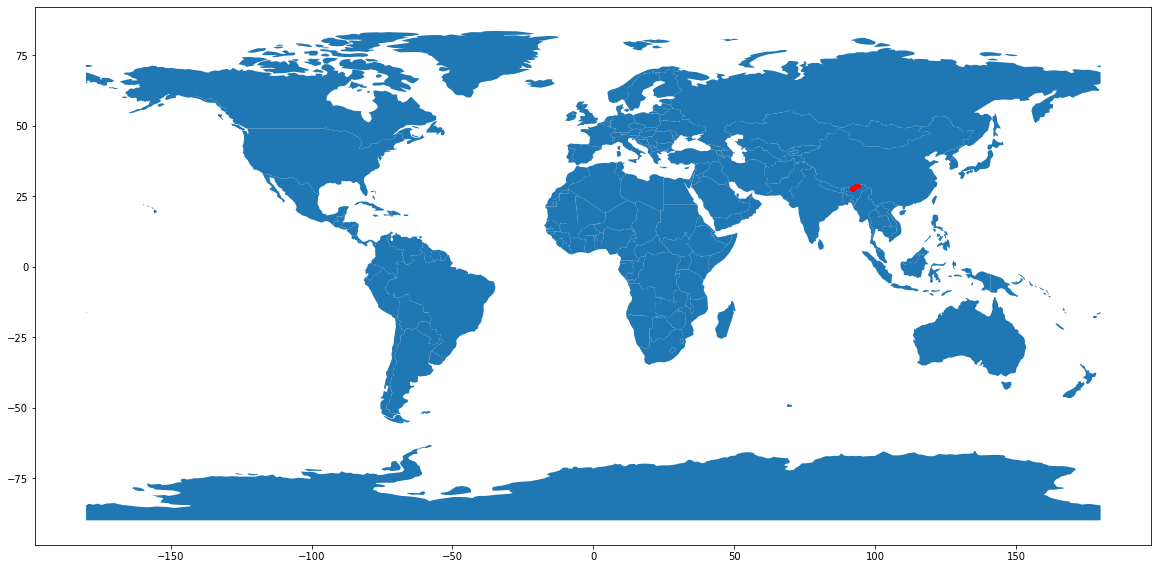

In [50]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(20, 10)), marker='o', color='red' , markersize=10)
## This code here will display your latitude and longitude on a world map

In [51]:
MultiPoly = cascaded_union(polygons)
geom = shapely.geometry.mapping(MultiPoly)
json.dumps(geom)


'{"type": "MultiPolygon", "coordinates": [[[[93.34452969408413, 28.461252819373744], [93.34449067990616, 28.428852361486456], [93.08930932009383, 28.428852361486456], [93.08903770087466, 28.654426435571473], [93.10313737182965, 28.654426435571473], [93.10308608616938, 28.696925622536806], [93.10758575273164, 28.696925622536806], [93.10753362831646, 28.74002479724961], [93.15413349666275, 28.74002479724961], [93.1541149786261, 28.755324504094993], [93.19651487492335, 28.755324504094993], [93.1965004632452, 28.767224276018027], [93.2954004353782, 28.767224276018027], [93.29539668048079, 28.7703242165933], [93.34359659100748, 28.7703242165933], [93.34358422974353, 28.780524021038335], [93.4899841419285, 28.780524021038335], [93.48997201684963, 28.790523829275585], [93.55307147714794, 28.790523829275585], [93.55297114523782, 28.872922247560123], [93.71617079234636, 28.872922247560123], [93.71611489485325, 28.91872136717874], [93.97248510514677, 28.91872136717874], [93.9724582548227, 28.896